In [6]:
import numpy as np 
import matplotlib.pyplot as plt
from casadi import *
import GPy
from scipy.optimize import minimize

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import bayesoptlib as CBO

In [2]:

def f1(x):
    return (x)**4 + (x)**3 - 2*(x)**2 - 2*(x)

def f2(x):
    return 0.5*(x)**2

def f(x):
    return f1(x[0]) +  f2(x[1])
def consensus(x):
    return x[0] + x[1]
bnds = ((-4, 4), (-4, 4))
sol = minimize(f, (0,0), method='SLSQP',bounds = bnds,constraints= {"fun": consensus, "type": "eq"})
print(sol.x,sol.fun)


bounds1 = np.array([[-4,4]])
bounds2 = np.array([[-4,4]])

xmax = 0
rho = 1

def eval_augL1(x1):
    augL1 = f1(x1) 
    return np.array(augL1).reshape(-1,1)

def eval_augL2(x2):
    augL2 = f2(x2) 
    return np.array(augL2).reshape(-1,1)



[ 0.8433219 -0.8433219] -1.6478740828916745


In [3]:
# setup ADMM 
lam = 0
x1opt = 2
x2opt = 2
xavg = (x1opt + x2opt)/2
x1avg = xavg - x1opt
x2avg = xavg - x2opt

# historical data
X1_sample = (np.array([x1opt])).reshape(1,1)
X2_sample = (np.array([x2opt])).reshape(1,1)
Y1_sample = eval_augL1(X1_sample)
Y2_sample = eval_augL2(X2_sample)

print(Y1_sample,Y2_sample)


inputDim = 1
kernel =  GPy.kern.RBF(inputDim,lengthscale = 0.68,variance=1234.62)
kernel2 =  GPy.kern.RBF(inputDim,lengthscale = 0.68,variance=2)
mf = GPy.core.Mapping(inputDim,1)
def prior_mean(x):
    y = 0*(x[:,0])**2 
    return y.reshape(-1,1)
mf.f = prior_mean
mf.update_gradients = lambda a,b: None


def augL(X,lam=lam,xavg=x1avg,rho = rho):
    return lam*(X) + rho/2*(X+xavg)**2

[[12]] [[2.]]


In [4]:

for k in range(0,40):
    
    #---------------------------------------------------------------------------------------------------

    X1_grid = np.linspace(bounds1[:, 0].T, bounds1[:, 1].T, 1000).reshape(-1,1)
    CBO1 = CBO.bayesian_optimization(X1_sample,Y1_sample,
                                    mf = mf,
                                    bounds=bounds1,
                                    kernel = kernel,
                                    X_grid = X1_grid)
 
    CBO1.fit_gp()
    if k>10:
        CBO1.optimize_fit()
    CBO1.query_next('LCB',Aug=augL,args=(lam,x1avg,rho))
    X1_next = CBO1.X_next.reshape(-1,1)
    Y1_new = eval_augL1(X1_next)
    X1_sample = np.vstack((X1_sample, X1_next))
    Y1_sample = np.vstack((Y1_sample, Y1_new))
    #---------------------------------------------------------------------------------------------------

    X2_grid = np.linspace(bounds2[:, 0].T, bounds2[:, 1].T, 1000).reshape(-1,1)
    CBO2 = CBO.bayesian_optimization(X2_sample,Y2_sample,
                                    mf = mf,
                                    bounds=bounds2,
                                    kernel = kernel2,
                                    X_grid = X2_grid)
    
    CBO2.fit_gp()
    if k>10:
        CBO2.optimize_fit()
    CBO2.query_next('LCB',Aug=augL,args=(lam,x2avg,rho))
    X2_next = CBO2.X_next.reshape(-1,1)
    Y2_new = eval_augL2(X2_next)
    X2_sample = np.vstack((X2_sample, X2_next))
    Y2_sample = np.vstack((Y2_sample, Y2_new))
    #---------------------------------------------------------------------------------------------------

    xavg0 = xavg
    xavg = (X1_next + X2_next)/2
    lam = lam + rho*xavg
    x1avg = xavg-X1_next
    x2avg = xavg-X2_next

print("ADMM tolerance achieved after "+str(k+1)+" iteratons")
print(X1_next[:,0],X2_next[:,0],lam)
print(Y1_new+Y2_new)



ADMM tolerance achieved after 40 iteratons
[0.84292702] [-0.79937546] [[0.8195978]]
[[-1.68363673]]


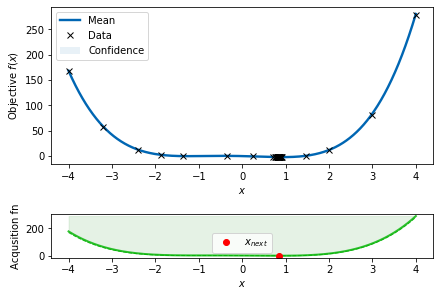

<Figure size 432x288 with 0 Axes>

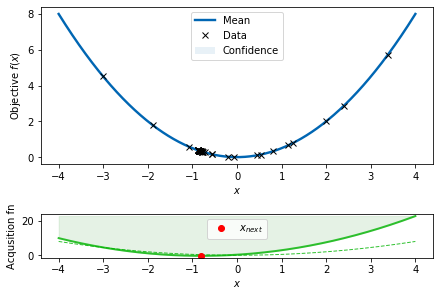

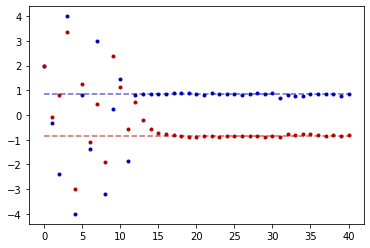

In [5]:
CBO1.plot()
plt.savefig('alloc1.pdf', bbox_inches='tight')
CBO2.plot()
plt.savefig('alloc2.pdf', bbox_inches='tight')

plt.plot(X1_sample[:,0],'.',color =(0,0,0.7))
plt.plot(0.8433+0*X1_sample,'--',color =(0,0,0.7,0.6))
plt.plot(X2_sample[:,0],'.',color =(0.7,0,0))
plt.plot(-0.8433+0*X1_sample,'--',color =(0.7,0,0,0.6))
plt.savefig('alloc.pdf', bbox_inches='tight')
